<a href="https://colab.research.google.com/github/jaya-shankar/education-impact/blob/master/primary_edu_OL_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!rm -rf education-impact

In [2]:
!git clone https://github.com/jaya-shankar/education-impact.git


Cloning into 'education-impact'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (300/300), done.
remote: Total 358 (delta 180), reused 176 (delta 55), pack-reused 0
Receiving objects: 100% (358/358), 2.87 MiB | 17.73 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [ ]:
!pip install tensorflow_decision_forests
!pip install wurlitzer
!pip install seaborn

In [5]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes

In [6]:
#@title Default title text
root = "education-impact/datasets/" 
datasets_path = {
                    "infant_mortality"                :  root+ "Infant_Mortality_Rate.csv",
                    "child_mortality"                 :  root+ "child_mortality_0_5_year_olds_dying_per_1000_born.csv",
                    "children_per_woman"              :  root+ "children_per_woman_total_fertility.csv",
                    "co2_emissions"                   :  root+ "co2_emissions_tonnes_per_person.csv",
                    "population"                      :  root+ "converted_pop.csv",
                    "population_density"              :  root+ "population_per_area.csv",
                    "gdp_growth"                      :  root+ "gdp_per_capita_yearly_growth.csv",
                    "Avg_daily_income_ppp"            :  root+ "mincpcap_cppp.csv",
                    "gdppercapita_us_infla_adjust"    :  root+ "gdppercapita_us_inflation_adjusted.csv",
                    "gini_index"                      :  root+ "gini.csv",
                    "life_expectancy"                 :  root+ "life_expectancy_years.csv",
                    "poverty_index"                   :  root+ "mincpcap_cppp.csv",
                    "people_in_poverty"               :  root+ "number_of_people_in_poverty.csv",
                    "ratio_b/g_in_primary"            :  root+ "ratio_of_girls_to_boys_in_primary_and_secondary_education_perc.csv",
                    "wcde-25--34"                     :  root+ "wcde-25--34.csv",
                    "20-24-In_Primary_OL"             :  root+ "In_Primary_OL.csv",
                    "20-24-Primary_OL"                :  root+ "Primary_OL.csv",
                    "20-24-Lower_Secondary_OL"        :  root+ "Lower_Secondary_OL.csv",
                    "20-24_female-In_Primary_OL"      :  root+ "female_In_Primary_OL.csv",
                    "20-24_female-Primary_OL"         :  root+ "female_Primary_OL.csv",
                    "20-24_female-Lower_Secondary_OL" :  root+ "female_Lower_Secondary_OL.csv"
                }

In [13]:
datasets_to_plot = [
            "life_expectancy",
            "infant_mortality",
            "child_mortality",
            "children_per_woman",
            "co2_emissions",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "20-24-In_Primary_OL",
            "20-24-Lower_Secondary_OL",
            "population",
            "population_density",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL",
            "20-24-Primary_OL"
            ]

output_y = "20-24-Primary_OL"
PREDICT_FUTURE  = 10
# creating a list of all countries & years
countries   = find_common_countries(datasets_to_plot)
years       = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys        = generate_indices(countries, years)

combined_df = load_datasets_to_pd(datasets_to_plot,keys,include_output=False)

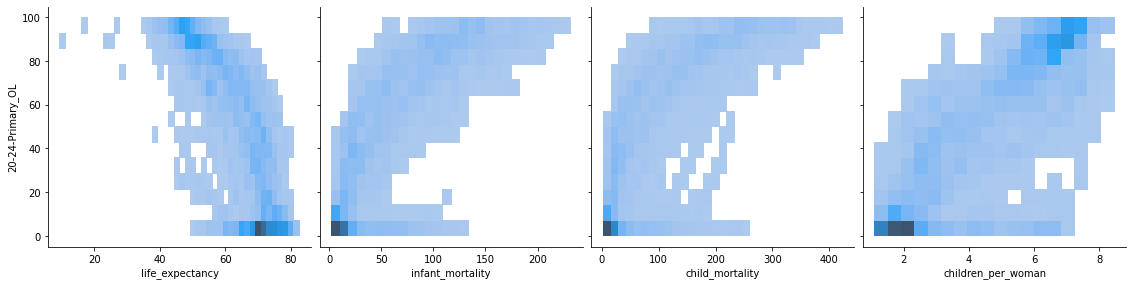

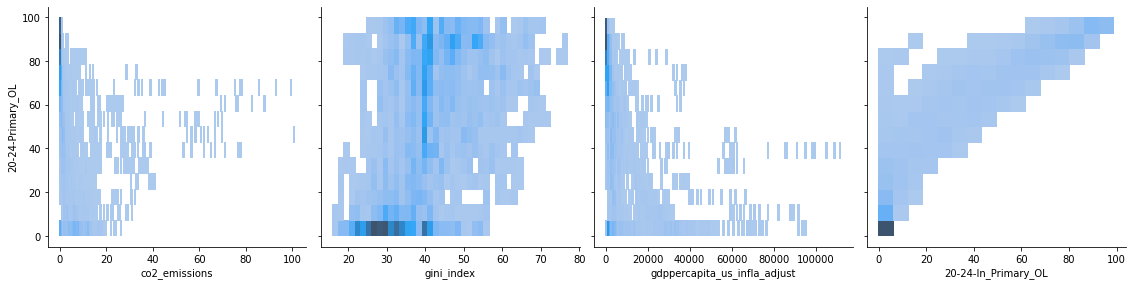

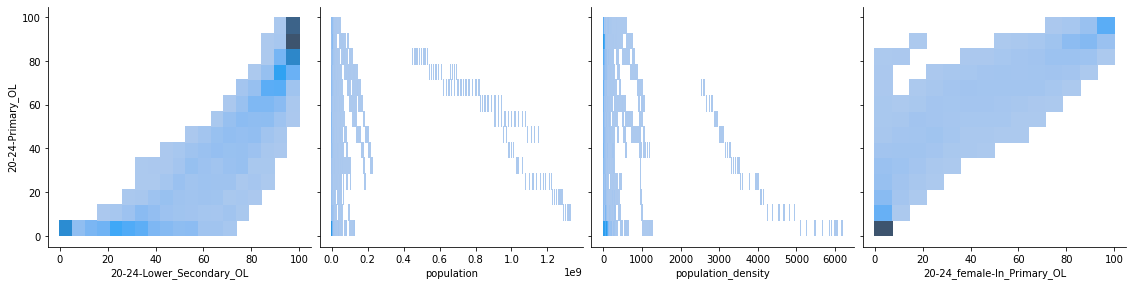

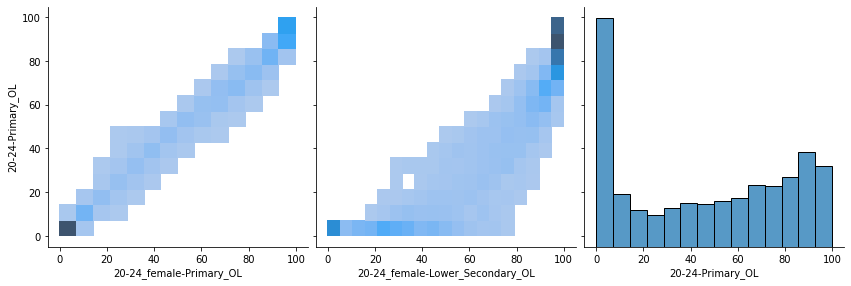

In [16]:
n = len(datasets_to_plot)
r = math.ceil(math.sqrt(n))
i=0
for m in range(r):
  plt = sns.pairplot(combined_df,kind="hist", y_vars=[output_y], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

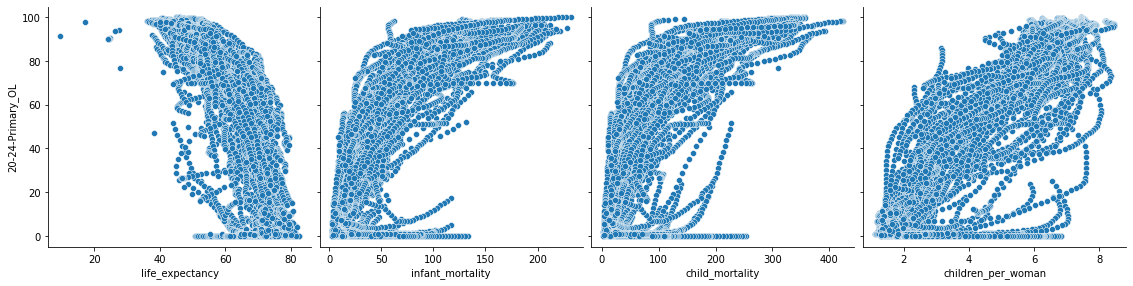

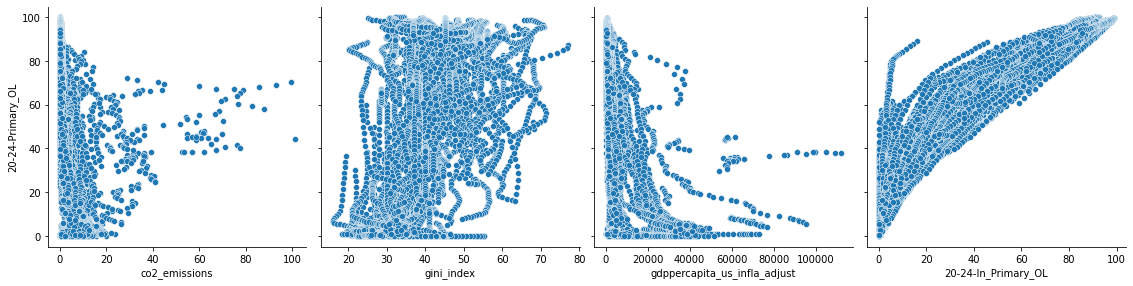

In [19]:
for m in range(r):
  plt = sns.pairplot(combined_df,kind="scatter", y_vars=[output_y], x_vars=[datasets_to_plot[i] for i in range(r*m,min(n,r*(m+1)))], height=4,dropna=True)
  plt

In [8]:
def get_countries_count(datasets):
  for dataset in datasets:
    df = pd.read_csv(datasets_path[dataset])
    count = len(set(df.Country.unique()))
    print(f"{'Factor: ' + dataset:<40} count: {count}")


In [9]:
def find_common_countries(datasets):
  common_countries = set()
  for dataset in datasets:
    countries_list = list(pd.read_csv(datasets_path[dataset]).Country)
    countries_list = set(map(lambda x: x.lower(), countries_list))
    if common_countries == set():
      common_countries = countries_list
    else:
      common_countries = common_countries.intersection(countries_list)
  return list(common_countries)

In [10]:
def generate_indices(countries,years):
  keys=[]
  for y in years:
    for c in countries:
      keys.append((c,str(y)))
  return keys

In [28]:
def load_datasets_to_pd(datasets,keys,include_output=True):
  combined_df = pd.DataFrame(keys,columns=['country','year'])
  for dataset in datasets:
    combined_df[dataset] = [math.nan]*len(combined_df)
    df = pd.read_csv(datasets_path[dataset])
    df["Country"] = df["Country"].str.lower()
    df.set_index("Country", inplace=True)
    for e in range(len(combined_df)):
      country = combined_df.iloc[e].country
      year    = combined_df.iloc[e].year
      combined_df.at[e,dataset] = df.loc[country][year]

  if include_output:
    label = "o_"+OUTPUT
    combined_df[label] = [math.nan]*len(combined_df)
    df = pd.read_csv(datasets_path[OUTPUT])
    df["Country"] = df["Country"].str.lower()
    df.set_index("Country", inplace=True)
    for e in range(len(combined_df)):
      country = combined_df.iloc[e].country
      year    = int(combined_df.iloc[e].year)
      combined_df.at[e,label] = df.loc[country][str( year + PREDICT_FUTURE )]
    combined_df.set_index(["country","year"], inplace=True)
  return combined_df

  

In [12]:
def combine_dfs(X,y):
  label = y.columns[0]
  X[label] = y
  X.dropna(subset=[label],inplace=True)
  return X

## Main Code starts from here

In [23]:
datasets = [
            "infant_mortality",
            "life_expectancy",
            "child_mortality",
            "children_per_woman",
            "co2_emissions",
            "gini_index",
            "gdppercapita_us_infla_adjust",
            "20-24-In_Primary_OL",
            "20-24-Primary_OL",
            "20-24-Lower_Secondary_OL",
            "population",
            "20-24_female-In_Primary_OL",
            "20-24_female-Primary_OL" ,
            "20-24_female-Lower_Secondary_OL"
            ]

In [24]:
PREDICT_FUTURE  = 10
OUTPUT         = '20-24-Primary_OL'
get_countries_count(datasets)

Factor: infant_mortality                 count: 266
Factor: life_expectancy                  count: 195
Factor: child_mortality                  count: 197
Factor: children_per_woman               count: 202
Factor: co2_emissions                    count: 194
Factor: gini_index                       count: 195
Factor: gdppercapita_us_infla_adjust     count: 207
Factor: 20-24-In_Primary_OL              count: 202
Factor: 20-24-Primary_OL                 count: 202
Factor: 20-24-Lower_Secondary_OL         count: 202
Factor: population                       count: 197
Factor: 20-24_female-In_Primary_OL       count: 202
Factor: 20-24_female-Primary_OL          count: 202
Factor: 20-24_female-Lower_Secondary_OL  count: 202


In [25]:
# creating a list of all countries & years
countries = find_common_countries(datasets)
years     = [y for y in range(1960,2015-PREDICT_FUTURE+1)]
keys      = generate_indices(countries, years)

In [26]:
len(countries)

153

In [29]:
input_df            = load_datasets_to_pd(datasets,keys)
output_df           = input_df[["o_" + OUTPUT]]
input_df.drop(labels=["o_" + OUTPUT], axis = 1, inplace=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(input_df, output_df, test_size=0.30, random_state=43)

In [31]:
X_train.isna().sum()

infant_mortality                    542
life_expectancy                       0
child_mortality                       0
children_per_woman                    0
co2_emissions                       104
gini_index                            0
gdppercapita_us_infla_adjust       1289
20-24-In_Primary_OL                   0
20-24-Primary_OL                      0
20-24-Lower_Secondary_OL              0
population                            0
20-24_female-In_Primary_OL            0
20-24_female-Primary_OL               0
20-24_female-Lower_Secondary_OL       0
dtype: int64

In [32]:
y_train.isna().sum()

o_20-24-Primary_OL    0
dtype: int64

In [33]:
X_train

infant_mortality  ...  20-24_female-Lower_Secondary_OL
country                year                    ...                                 
india                  1968             146.0  ...                            99.30
bosnia and herzegovina 1975               NaN  ...                            68.90
fiji                   1989              25.1  ...                            66.96
niger                  1972             134.7  ...                           100.06
sierra leone           1973             182.1  ...                            99.62
...                                       ...  ...                              ...
turkmenistan           2000              57.6  ...                             6.20
canada                 1975              14.1  ...                            37.40
lebanon                1975              44.2  ...                            89.50
tunisia                1982              61.9  ...                            96.18
ghana                  1998              68.3  ...                            86.40

[4926 rows x 14 columns]

In [ ]:
y_train

o_life_expectancy
country     year                   
latvia      1966               69.5
yemen       1963               46.6
mexico      1987               72.9
chad        2005               58.8
zambia      1986               46.1
...                             ...
switzerland 1999               82.5
belarus     1974               70.5
guyana      1974               62.1
tonga       1981               71.1
austria     1997               80.3

[5087 rows x 1 columns]

In [34]:
combine_dfs(X_test,y_test)

infant_mortality  ...  o_20-24-Primary_OL
country             year                    ...                    
mozambique          1985             172.2  ...               87.10
madagascar          1990              96.2  ...               86.50
                    1960               NaN  ...               90.80
solomon islands     2001              25.0  ...               53.78
brazil              2005              22.0  ...               22.20
...                                    ...  ...                 ...
latvia              1969               NaN  ...                0.60
papua new guinea    1967             108.1  ...                0.00
trinidad and tobago 1998              25.1  ...                8.18
tunisia             1970             121.2  ...               74.00
ethiopia            1960               NaN  ...               97.60

[2112 rows x 15 columns]

In [36]:

# converting pandas to tensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

model.fit(x=train_ds)
# Convert it to a TensorFlow dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(combine_dfs(X_train,y_train), label="o_"+OUTPUT, task=tfdf.keras.Task.REGRESSION)

# Evaluate the model
model.compile(metrics=["mse"])
# Evaluate the model on the test dataset.
evaluation = model.evaluate(test_ds, return_dict=True)
print(OUTPUT.upper())
print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")
print()

77/77 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - mse: 3.2884
20-24-PRIMARY_OL
{'loss': 0.0, 'mse': 3.288381814956665}

MSE: 3.288381814956665
RMSE: 1.8133895927121302



In [37]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

In [ ]:
# %set_cell_height 300

model.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (9):
	20-24-In_Primary_OL
	20-24-Primary_OL
	20-24_female-In_Primary_OL
	20-24_female-Primary_OL
	children_per_woman
	co2_emissions
	gdppercapita_us_infla_adjust
	gini_index
	population

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.                      "__LABEL" 11.444041 ################
    2.          "20-24-In_Primary_OL"  7.982767 #########
    3.   "20-24_female-In_Primary_OL"  7.905015 #########
    4.                   "population"  7.126443 ########
    5.                   "gini_index"  6.084543 ######
    6.                "co2_emissions"  5.720220 #####
    7.             "20-24-Primary_OL"  5.193484 #####
  

# CNN Algorithm

from the above output
- **malnutrition & people in povery** have least no of countries
- **infant mortality & gdp per captia** have highest no of countries

*Doubt:* Does having more data for one factor will make the decision tree bias?


###Steps
1. create a csv file such that each row contains all values of particular year & country present
2. the output for each row is year + 40 years corresponding value 
    1. **outputs** - life expectany, education level, gdp




From above output
- if we dont drop any rows our table size = 4256 entries
- if we drop rows containing any if all of outputs missing then our table size = 3039 entries
- if we drop rows containing any one of output missing then our table size = 1745 entries

so, I think its is better to go with second choice and build different models, but not sure it will not effect performance of the model


now we have the dataframe containing both inputs and ouputs,our next step is
1. split the data into train & test data
  1. try to split data based on continents to reduce bias
2. build DF model using tensorflow
3. check the accuracy of the model